This is a test for the volume & surface integral functionality. 

Various mesh are integrated over, with checks made against things like total volume, surface area and function integration. 

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import math

In [2]:
minCoord = [-2.,-1.]
maxCoord = [ 2., 1.]
meshq1 = uw.mesh.FeMesh_Cartesian(elementType='Q1', elementRes=(16,16), minCoord=minCoord, maxCoord=maxCoord)
meshq2 = uw.mesh.FeMesh_Cartesian(elementType='Q2', elementRes=(16,16), minCoord=minCoord, maxCoord=maxCoord)

	Global element size: 16x16
	Local offset of rank 0: 0x0
	Local range of rank 0: 16x16
	Global element size: 16x16
	Local offset of rank 0: 0x0
	Local range of rank 0: 16x16



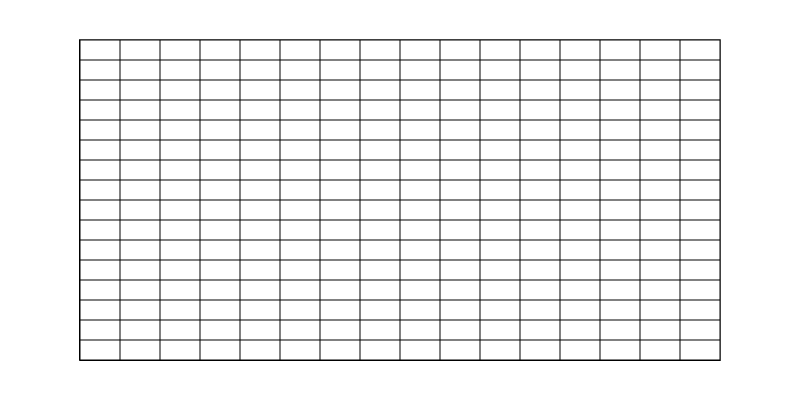

In [3]:
meshfig = vis.Figure(figsize=(800,400))
meshfig.append( vis.objects.Mesh(meshq1) )
meshfig.show()

In [4]:
def checkSurfaceIntegration(mesh, value, fn=1., rtol=1e-05):
    """
    This function performs surface integration across the entire boundary of the 
    provided mesh. The surface integration of 'fn' is expected to return a result 
    with 'rtol' of 'value'.
    
    Parameters
    ----------
        mesh : uw.mesh.FeMesh
            The mesh across which integration is to be performed.
        value: float
            The expected result of the integration.
        fn   : uw.function.Function
            The function which is to be integrated.
        rtol : float
            Relative tolerance. Check allclose documentation for details.
    """
    boundaryLength = uw.utils.Integral( fn=fn, mesh=mesh, integrationType='Surface', surfaceIndexSet=mesh.specialSets["AllWalls_VertexSet"])
    result = boundaryLength.evaluate()
    assert np.allclose( result, value, rtol=rtol ), "Error occurred in surface integration. Integration = {}, Expected = {}".format(result, value)
def checkVolumeIntegration(mesh, value, fn=1., rtol=1e-05):
    """
    This function performs volume integration across the entire volume of the 
    provided mesh. The volume integration of 'fn' is expected to return a result 
    with 'rtol' of 'value'.
    
    Parameters
    ----------
        mesh : uw.mesh.FeMesh
            The mesh across which integration is to be performed.
        value: float
            The expected result of the integration.
        fn   : uw.function.Function
            The function which is to be integrated.
        rtol : float
            Relative tolerance. Check allclose documentation for details.
    """

    totalVolume = uw.utils.Integral( fn=fn, mesh=mesh, integrationType='Volume')
    result = totalVolume.evaluate()
    assert np.allclose( result, value, rtol=rtol ), "Error occurred in volume integration. Integration = {}, Expected = {}".format(result, value)

In [5]:
def correctLength(minCoord,maxCoord):
    """ Calculates the total boundary length of a mesh created using minCoord,maxCoord. """
    return 2.*sum( maxCoord[ii] - minCoord[ii] for ii in range(0,len(minCoord)))
def correctVol(minCoord,maxCoord):
    """ Calculates the volume of a mesh created using minCoord,maxCoord. """
    return np.prod( [ maxCoord[ii] - minCoord[ii] for ii in range(0,len(minCoord)) ] ) 

In [6]:
# check we are getting correct 
for mesh in [meshq1,meshq2]:
    mesh.reset()
    checkSurfaceIntegration(mesh, correctLength(minCoord,maxCoord)) 
    checkVolumeIntegration(mesh, correctVol(minCoord,maxCoord))


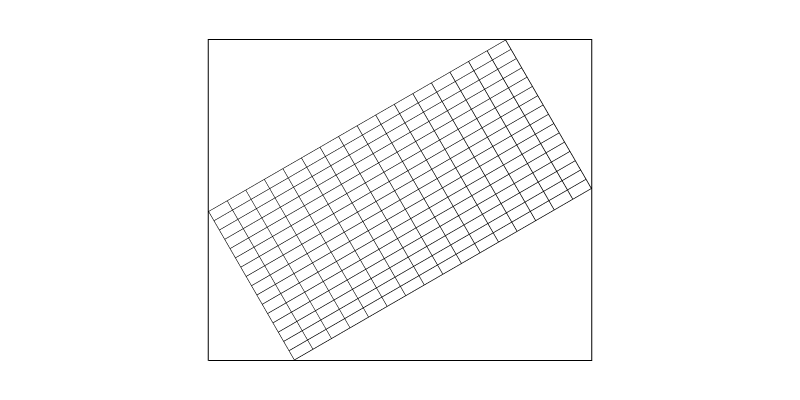

In [7]:
# lets rotate and try again
def rotate(mesh):
    with mesh.deform_mesh():
        for vert in mesh.data[:]:
            radius = np.linalg.norm(vert[0:2])
            angle  = np.arctan2(vert[1],vert[0])
            vert[0] = radius*math.cos(angle+math.pi/6.)
            vert[1] = radius*math.sin(angle+math.pi/6.)
# check
for mesh in [meshq1,meshq2]:
    mesh.reset()
    rotate(mesh)
    checkSurfaceIntegration(mesh, correctLength(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
meshfig.show()


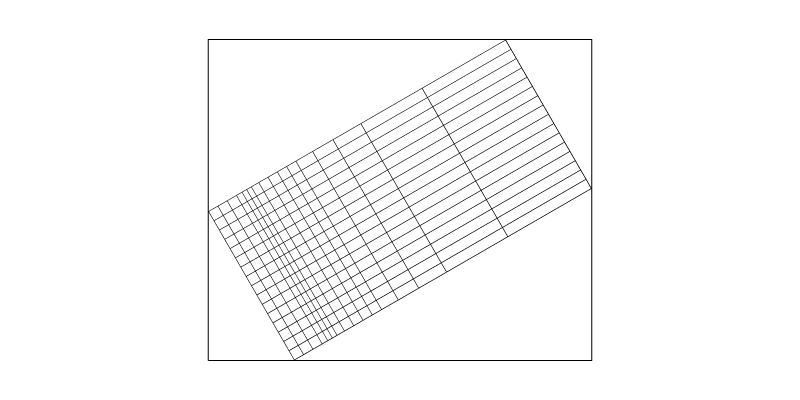

In [8]:
def refine(mesh, minCoord, maxCoord):
    # lets do some refinement and check
    xp = np.array( (0., 0.10, 0.20, 0.300, 0.40, 0.5, 0.60, 0.70, 0.8, 0.90, 1.0) )
    yp = np.array( (0., 0.05, 0.10, 0.125, 0.15, 0.2, 0.25, 0.30, 0.4, 0.55, 1.0) )
    # scale to domain
    xp = xp*(maxCoord[0]-minCoord[0]) - maxCoord[0]
    yp = yp*(maxCoord[0]-minCoord[0]) - maxCoord[0]
    with mesh.deform_mesh():
        mesh.data[:,0] = np.interp( mesh.data[:,0], xp, yp) 

# check
for mesh in [meshq1,meshq2]:
    mesh.reset()
    refine(mesh, minCoord, maxCoord)
    checkSurfaceIntegration(mesh, correctLength(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
    rotate(mesh)
    checkSurfaceIntegration(mesh, correctLength(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
meshfig.show()

	Global element size: 16x16
	Local offset of rank 0: 0x0
	Local range of rank 0: 16x16
	Global element size: 16x16
	Local offset of rank 0: 0x0
	Local range of rank 0: 16x16



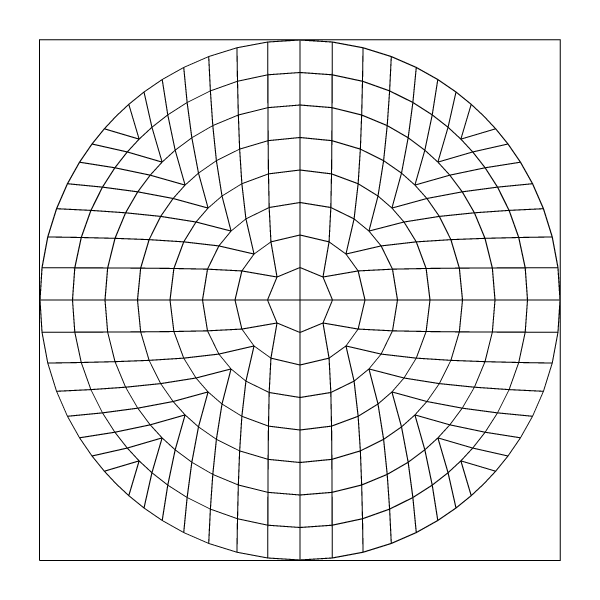

In [9]:
# giordani mesh 
minCoord = [-1.,-1.]
maxCoord = [ 1., 1.]
meshq1 = uw.mesh.FeMesh_Cartesian(elementType='Q1', elementRes=(16,16), minCoord=minCoord, maxCoord=maxCoord)
meshq2 = uw.mesh.FeMesh_Cartesian(elementType='Q2', elementRes=(16,16), minCoord=minCoord, maxCoord=maxCoord)
def circleMesh(mesh):
    with mesh.deform_mesh():
        for vert in mesh.data[:]:
            radius = np.max(np.abs(vert))
            angle = np.arctan2(vert[1],vert[0])
            vert[0] = radius*math.cos(angle)
            vert[1] = radius*math.sin(angle)

# check.. note we need to use a lower tolerance for the q1 mesh because it always 
# under-integrates due to the mesh 'cutting corners'
for index,mesh in enumerate([meshq1,meshq2]):
    rtols = [1e-2,1e-5]
    mesh.reset()
    circleMesh(mesh)
    checkSurfaceIntegration(mesh, 2.*math.pi, rtol=rtols[index]) 
    checkVolumeIntegration( mesh, math.pi, rtol=rtols[index])

meshfig = vis.Figure(figsize=(600,600))
meshfig.append( vis.objects.Mesh(meshq1) )
meshfig.show()

	Global element size: 8x8x8
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 8x8x8
	Global element size: 8x8x8
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 8x8x8



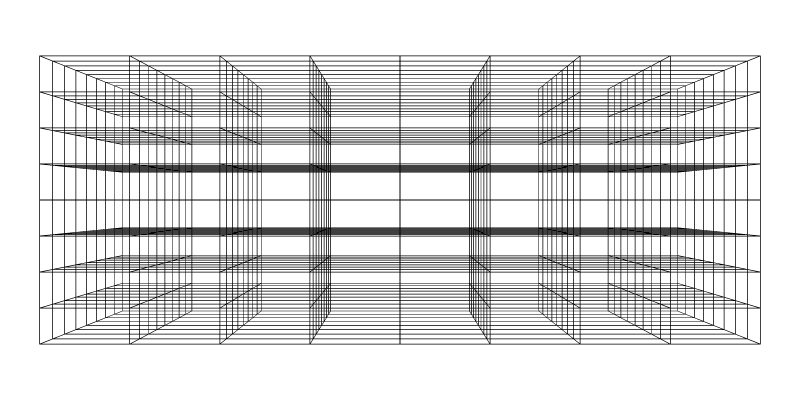

In [10]:
# lets do some 3d tests
minCoord = [-5.,-2.,-1.]
maxCoord = [ 5., 2., 1.]
meshq1 = uw.mesh.FeMesh_Cartesian(elementType='Q1', elementRes=(8,8,8), minCoord=minCoord, maxCoord=maxCoord)
meshq2 = uw.mesh.FeMesh_Cartesian(elementType='Q2', elementRes=(8,8,8), minCoord=minCoord, maxCoord=maxCoord)

def correctSurface(minCoord,maxCoord):
    val  = 0.
    val += ( maxCoord[0] - minCoord[0] )*( maxCoord[1] - minCoord[1] )  
    val += ( maxCoord[0] - minCoord[0] )*( maxCoord[2] - minCoord[2] )  
    val += ( maxCoord[1] - minCoord[1] )*( maxCoord[2] - minCoord[2] )  
    return 2*val

for mesh in [meshq1,meshq2]:
    mesh.reset()
    checkSurfaceIntegration(mesh, correctSurface(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
meshfig = vis.Figure(figsize=(800,400))
meshfig.append( vis.objects.Mesh(meshq1) )
meshfig.show()


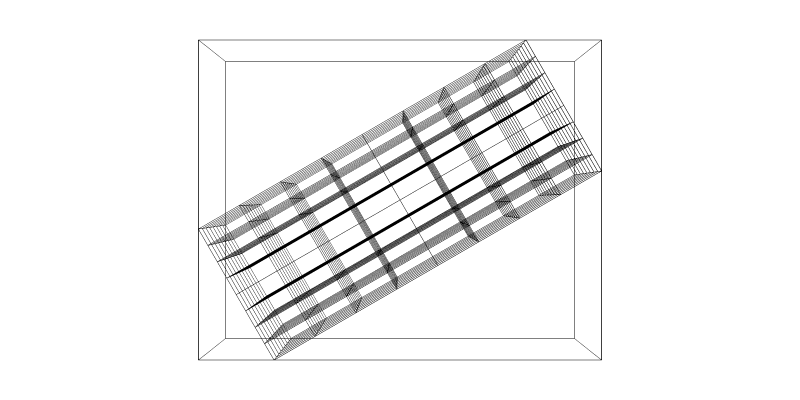

In [11]:
# check
for mesh in [meshq1,meshq2]:
    mesh.reset()
    rotate(mesh)
    checkSurfaceIntegration(mesh, correctSurface(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
meshfig.show()


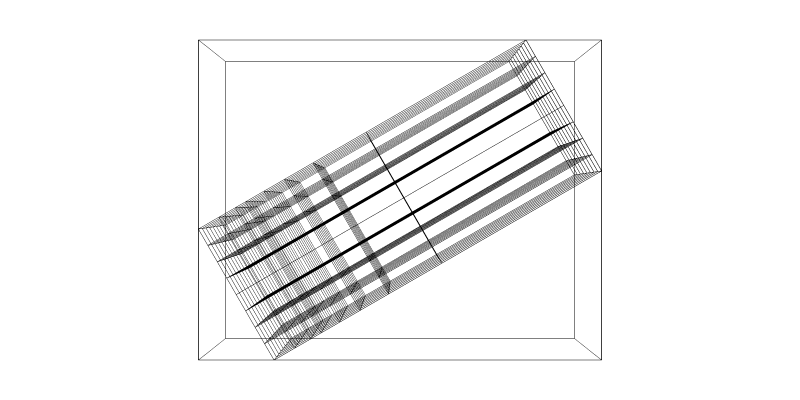

In [12]:
# refine, check, rotate, check
for mesh in [meshq1,meshq2]:
    mesh.reset()
    refine(mesh, minCoord, maxCoord)
    checkSurfaceIntegration(mesh, correctSurface(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
    rotate(mesh)
    checkSurfaceIntegration(mesh, correctSurface(minCoord,maxCoord)) 
    checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))
meshfig.show()

	Global element size: 16x16x16
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 16x16x16
	Global element size: 16x16x16
	Local offset of rank 0: 0x0x0
	Local range of rank 0: 16x16x16



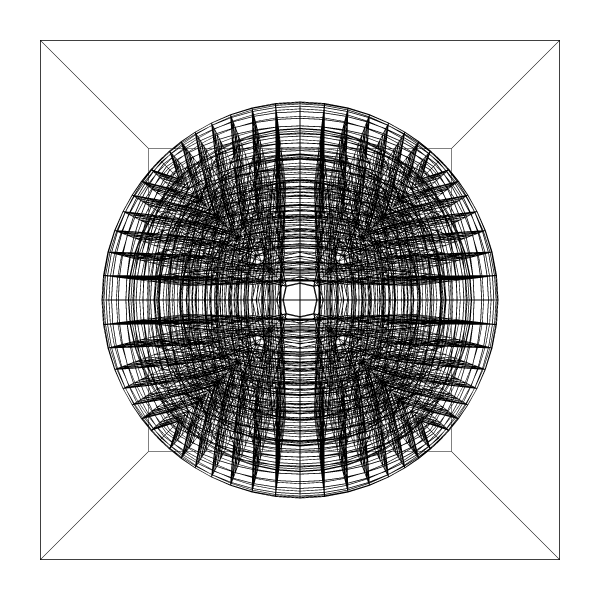

In [13]:
# giordani mesh 
minCoord = [-1.,-1.,-1.]
maxCoord = [ 1., 1., 1.]
meshq1 = uw.mesh.FeMesh_Cartesian(elementType='Q1', elementRes=(16,16,16), minCoord=minCoord, maxCoord=maxCoord)
meshq2 = uw.mesh.FeMesh_Cartesian(elementType='Q2', elementRes=(16,16,16), minCoord=minCoord, maxCoord=maxCoord)
def sphereMesh(mesh):
    with mesh.deform_mesh():
        for vert in mesh.data[:]:
            radius = np.max(np.abs(vert))
            angle1 = np.arctan2(vert[1],vert[0])
            angle2 = np.arctan2(vert[2],np.linalg.norm(vert[0:2]))
            distinplane = radius*math.cos(angle2)
            vert[0] = distinplane*math.cos(angle1)
            vert[1] = distinplane*math.sin(angle1)
            vert[2] = radius*math.sin(angle2)

# check.. note we need to use a lower tolerance for the q1 mesh because it always 
# under-integrates due to the mesh 'cutting corners'
for index,mesh in enumerate([meshq1,meshq2]):
    rtols = [1e-2,1e-5]
    mesh.reset()
    sphereMesh(mesh)
    checkSurfaceIntegration(mesh,    4.*math.pi, rtol=rtols[index]) 
    checkVolumeIntegration( mesh, 4./3.*math.pi, rtol=rtols[index])

meshfig = vis.Figure(figsize=(600,600))
meshfig.append( vis.objects.Mesh(meshq1) )
meshfig.show()

In [14]:
# integrate radial function
import underworld.function as fn
coord = fn.input()
r = fn.math.sqrt( fn.math.dot(coord,coord) )  # exact solution for integration across unit sphere is \pi

for index,mesh in enumerate([meshq1,meshq2]):
    rtols = [1e-2,1e-5]
    checkVolumeIntegration( mesh, math.pi, fn=r, rtol=rtols[index])

# lets also integrate just one eighth of sphere surface
func = fn.branching.conditional( [ ( (coord[0]>0.) & (coord[1]>0.) & (coord[2] > 0.), 1.),
                                   (                                           True , 0.) ] ) 
for index,mesh in enumerate([meshq1,meshq2]):
    rtols = [1e-2,1e-5]
    checkSurfaceIntegration( mesh,  1./2.*math.pi, fn=func, rtol=rtols[index])

In [15]:
# finally let's add an empty surface integral tests.
# this is in particular important for parallel surface integrations
# where often some procs have empty sets. it should return
# a valid result, zero. 
zero = uw.utils.Integral( fn=1., mesh=meshq1, integrationType='Surface', surfaceIndexSet=meshq1.specialSets["Empty"])
result = zero.evaluate()
assert np.allclose( result, 0., rtol=1e-5 ), "Error occurred in surface integration. Integration = {}, Expected = {}".format(result[0], 0.)